In [7]:
# installing necessary libraries
!pip install textblob
!pip install wordcloud
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/396.4 kB ? eta -:--:--
     ------ -------------------------------- 61.4/396.4 kB 1.1 MB/s eta 0:00:01
     ----------- -------------------------- 122.9/396.4 kB 1.4 MB/s eta 0:00:01
     -------------------------- ----------- 276.5/396.4 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 396.4/396.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43341 sha256=b7131e7b7adbaca08a8e7d5635417e2f341ca398097156b207827b8ecbf183dc
  Stored in directory: c:\users\sandin maheeshakya\appdata\local\pip\cache\wheels\ed\ac\fa\7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex


In [1]:
#Importing the Libraries
import pandas as pd
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict, Counter

from nrclex import NRCLex

[nltk_data] Downloading package punkt to C:\Users\Sandin
[nltk_data]     Maheeshakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sandin
[nltk_data]     Maheeshakya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


oh            1500
love          1443
like          1375
let           1199
go            1148
got           1142
baby          1028
know           950
na             852
see            796
get            640
girl           595
come           564
wan            564
want           551
ai             511
hey            499
boy            492
feel           488
yeah           487
one            479
back           470
right          463
time           453
ca             443
say            436
take           404
never          401
gon            398
halo           383
check          366
need           361
good           355
way            351
make           348
tonight        346
girls          341
ya             337
put            327
run            325
looking        314
crazy          308
world          306
uh             304
body           296
think          290
around         289
everything     288
wo             280
could          274
dtype: int64


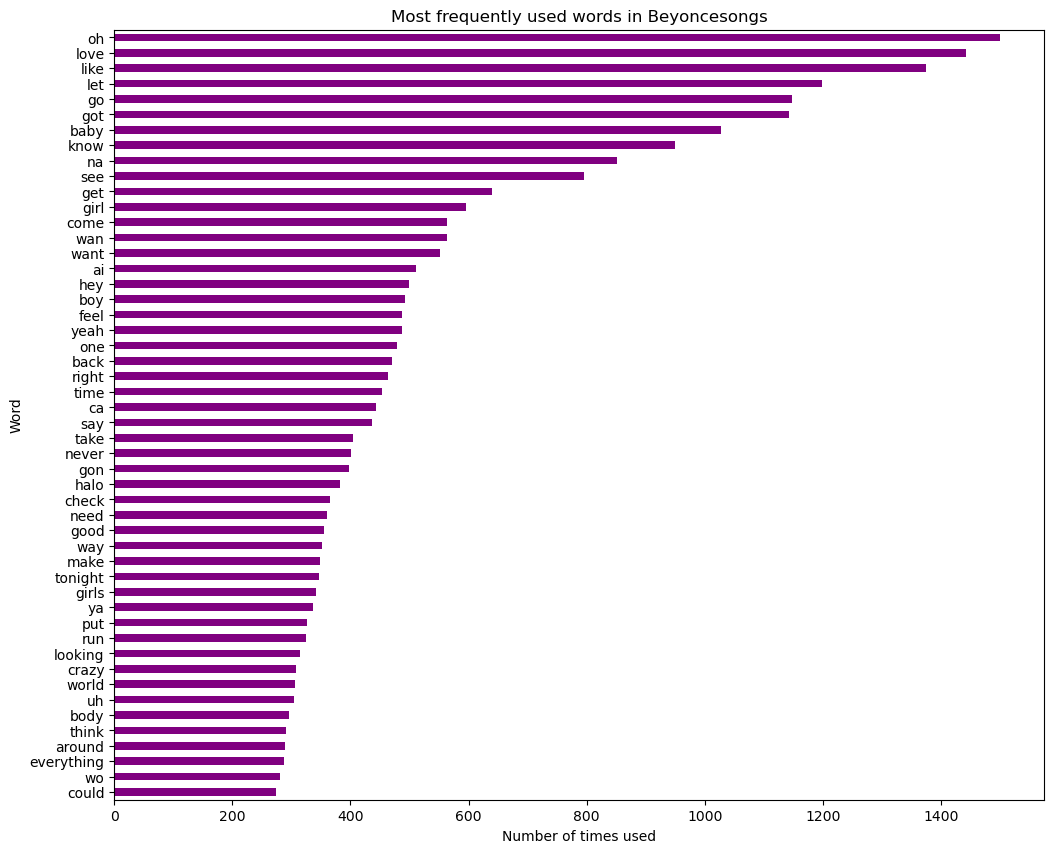

In [2]:

# Ensure NLTK components are available
nltk.download('punkt')
nltk.download('stopwords')

# Reading the data
all_lyrics = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-29/beyonce_lyrics.csv')


# Tokenize and clean the data
stop_words = set(stopwords.words('english'))
all_lyrics['tokens'] = all_lyrics['line'].apply(lambda x: [word.lower() for word in word_tokenize(str(x)) if word.isalpha() and word.lower() not in stop_words])

# Flatten the list of tokens and count word frequencies
all_words = [word for tokens in all_lyrics['tokens'] for word in tokens]
word_freq = pd.Series(all_words).value_counts()

# Display the most popular words
most_popular_words = word_freq.head(50)
print(most_popular_words)

# Create a horizontal bar plot
plt.figure(figsize=(12, 10))
most_popular_words.sort_values().plot(kind='barh', color='purple')
plt.title('Most frequently used words in Beyonce songs')
plt.xlabel('Number of times used')
plt.ylabel('Word')
plt.show()

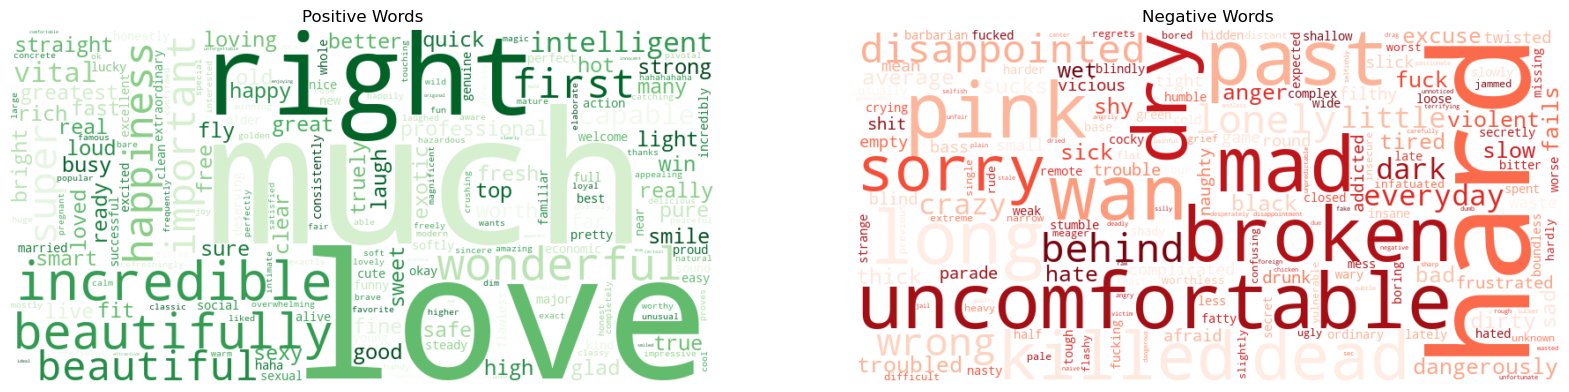

In [8]:
# Define colors (adjust the hex values to your liking or get them from somewhere else)
beyonce_colors = {"positive": "#1db954", "negative": "#eb4034"}

# Read the data (we'll just use the previously combined dataframe `all_lyrics`)
# Assuming `all_lyrics` is already defined and contains the combined lyrics data

# Filter out specific words
words_to_filter = ["oh","ooh", "yeah", "ah", "uh", "ha", "whoa", "eh", "hoo", "ey", "mmm", "eeh", "huh", "na"]
all_lyrics['filtered_tokens'] = all_lyrics['tokens'].apply(lambda x: [word for word in x if word not in words_to_filter])

# Flatten the list of tokens and perform sentiment analysis
all_words = [word for tokens in all_lyrics['filtered_tokens'] for word in tokens]
sentiments = {word: TextBlob(word).sentiment.polarity for word in all_words}

# Separate words by sentiment
positive_words = ' '.join([word for word, sentiment in sentiments.items() if sentiment > 0])
negative_words = ' '.join([word for word, sentiment in sentiments.items() if sentiment < 0])

# Generate the word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()
     

In [10]:
# Initialize the TF-IDF Vectorizer with English stopword
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(all_lyrics['line'])

# Create a DataFrame for TF-IDF vectors and add the album names
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=all_lyrics.index, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['song_name'] = all_lyrics['song_name']

# Calculate the TF-IDF score for each word-album combination
tfidf_df = tfidf_df.melt(id_vars='song_name', var_name='Word', value_name='TF-IDF')

# Get the top 10 words for each album based on TF-IDF score
top_tfidf = tfidf_df.groupby('song_name').apply(lambda x: x.nlargest(10, 'TF-IDF')).reset_index(drop=True)

# Define color palette for albums
album_colors = sns.color_palette("pastel", len(all_lyrics['song_name'].unique()))
color_dict = dict(zip(all_lyrics['song_name'].unique(), album_colors))

# Plot setup
songs = top_tfidf['Album'].unique()
n_songs = len(songs)
n_cols = 3  
n_rows = n_songs // n_cols + (n_songs % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows), sharex=False, sharey=False)
axes = axes.flatten()

# Plot each song's important words in a separate subplot
for i, song in enumerate(songs):
    ax = axes[i] if n_songs > 1 else axes
    data = top_tfidf[top_tfidf['song_name'] == song]
    sns.barplot(x='TF-IDF', y='Word', data=data, ax=ax, color=color_dict[song])
    ax.set_title(song)
    ax.set_xlabel('tf-idf')
    ax.set_ylabel('')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 1.01 GiB for an array with shape (135696000,) and data type int64

# Emotion in Beyonce Songs

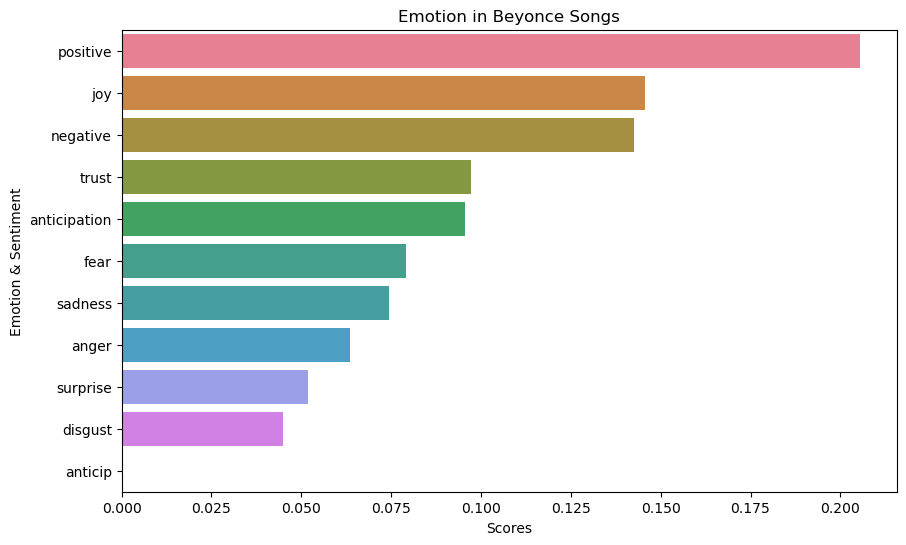

In [11]:
# Flatten the list of tokens into a single list of words
all_words = [word for sublist in all_lyrics['tokens'] for word in sublist]

# Create a single string of words for sentiment analysis
lyrics_str = ' '.join(all_words)

# Perform sentiment analysis using NRCLex
text_object = NRCLex(lyrics_str)

# Calculate sentiment frequency
sentiment_freq = text_object.affect_frequencies

# Convert to DataFrame
sentimentscores = pd.DataFrame(list(sentiment_freq.items()), columns=['Sentiment', 'Score'])

# Plotting the sentiment scores using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Sentiment', data=sentimentscores.sort_values('Score', ascending=False), palette='husl')
plt.title('Emotion in Beyonce Songs')
plt.xlabel('Scores')
plt.ylabel('Emotion & Sentiment')
plt.show()

In [12]:
# Filter words associated with "fear"
fear_words = ["bad", "mad", "hate", "feeling", "watch", "lose", "fight", "worship", "afraid", "death", "killing","shaking", "dying", "hell", "reckless", "bitch", "danger", "curse"]

# Count the frequency of fear-related words
fear_word_counts = {word: all_words.count(word) for word in fear_words}

# Convert to DataFrame and sort by count
fear_word_counts_df = pd.DataFrame(list(fear_word_counts.items()), columns=['Word', 'Count'])
fear_word_counts_df = fear_word_counts_df.sort_values(by='Count', ascending=False)

# Print the table
print(fear_word_counts_df)


        Word  Count
4      watch    178
0        bad    132
6      fight     74
1        mad     62
3    feeling     61
2       hate     48
5       lose     41
15     bitch     33
13      hell     28
8     afraid     20
9      death     15
10   killing     14
11   shaking      5
14  reckless      5
17     curse      4
16    danger      2
12     dying      1
7    worship      1


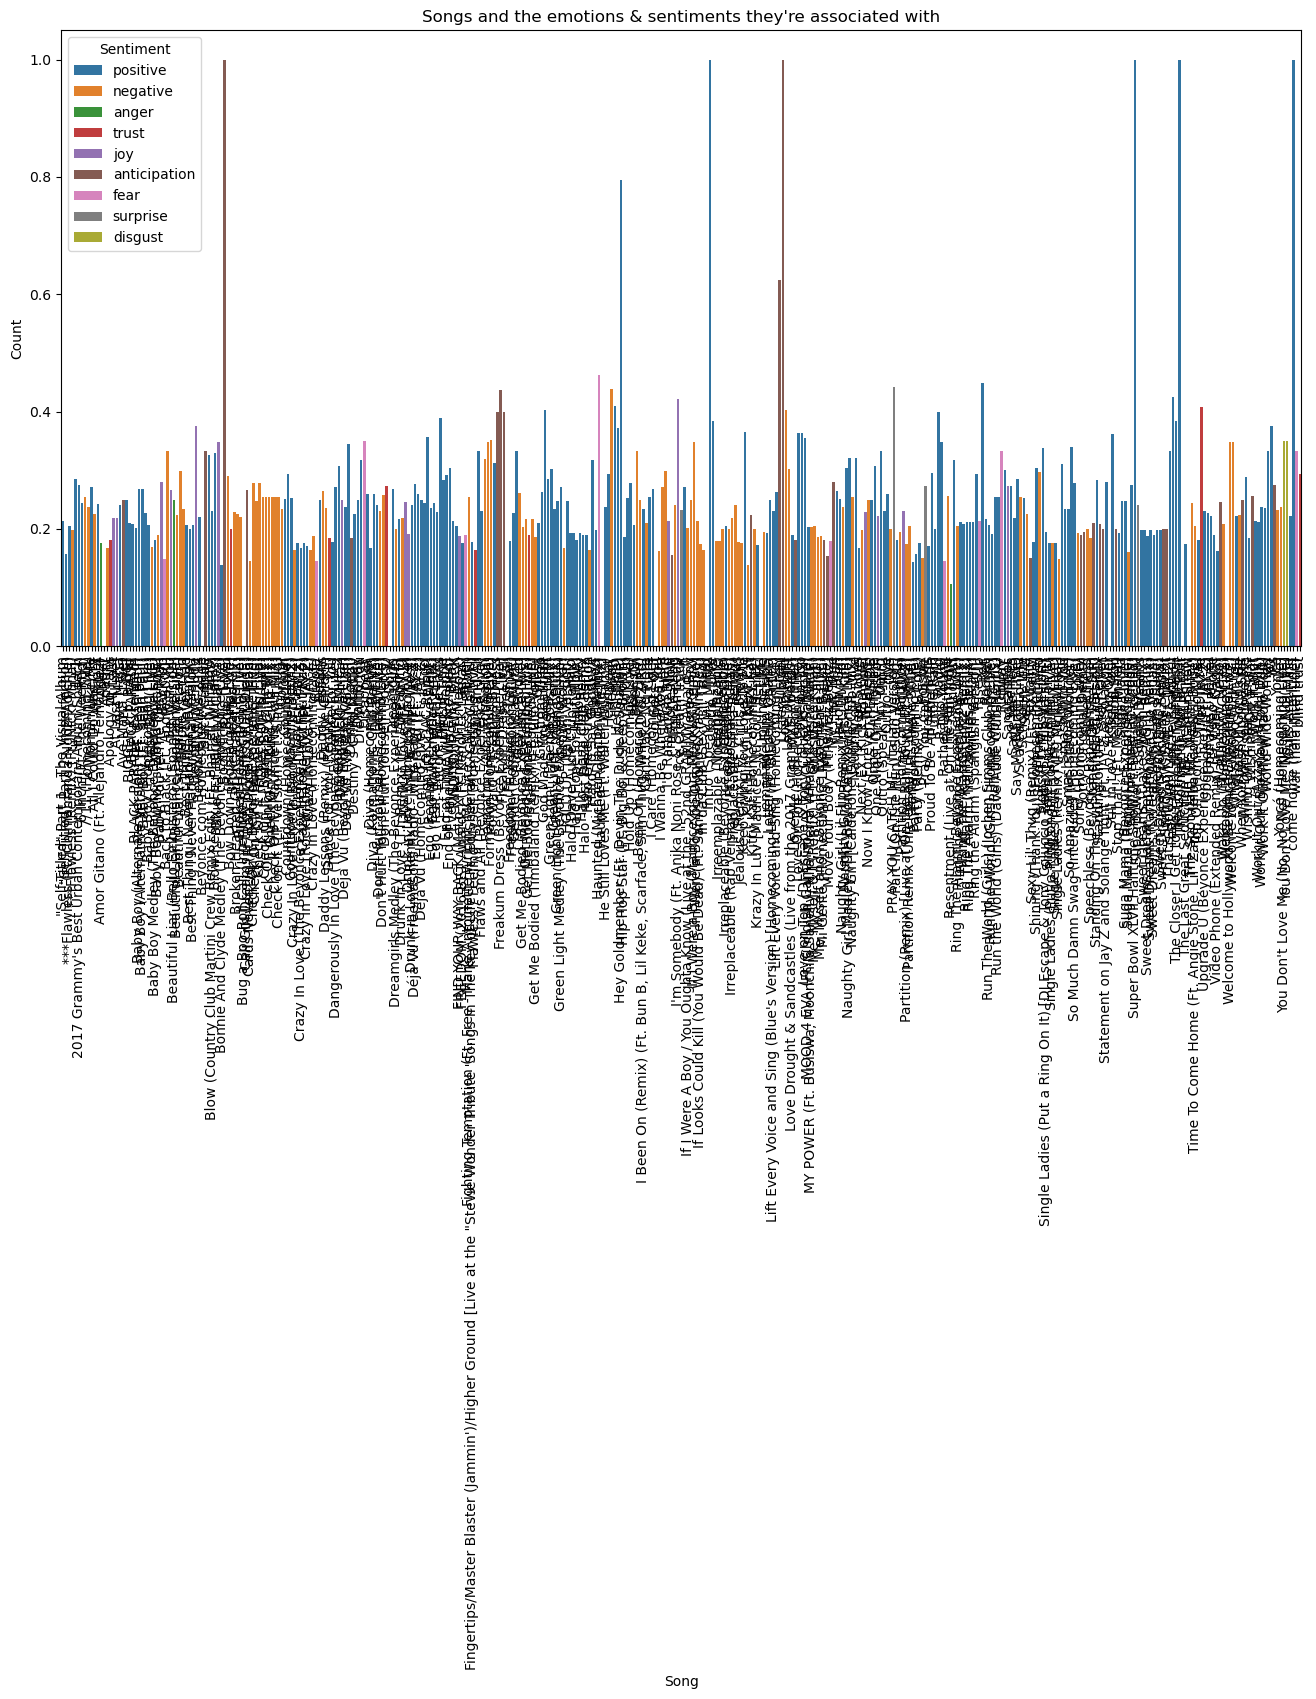

In [22]:

# Create a DataFrame for sentiment frequencies by album
song_sentiments = all_lyrics.groupby('song_name')['line'].apply(lambda x: ' '.join(x)).apply(NRCLex).apply(lambda x: x.affect_frequencies)

# Expand the nested dictionary into a DataFrame
expanded_sentiments = song_sentiments.apply(pd.Series).fillna(0).reset_index()

# Melt the DataFrame to have one row per album-sentiment combination
melted_sentiments = expanded_sentiments.melt(id_vars='song_name', var_name='Sentiment', value_name='Count')

# Sort the sentiments within each album and select the top 5
sorted_sentiments = (melted_sentiments
                     .groupby(['song_name', 'Sentiment'])
                     .sum()
                     .reset_index()
                     .sort_values(['song_name', 'Count'], ascending=[True, False]))

top_sentiments = sorted_sentiments.groupby('song_name').head(5)

# Plotting
plt.figure(figsize=(16, 8))
sns.barplot(data=top_sentiments, x='song_name', y='Count', hue='Sentiment', dodge=False)

# Customizing the plot to match the ggplot2 output
plt.title("Songs and the emotions & sentiments they're associated with")
plt.xlabel("Song")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title='Sentiment')

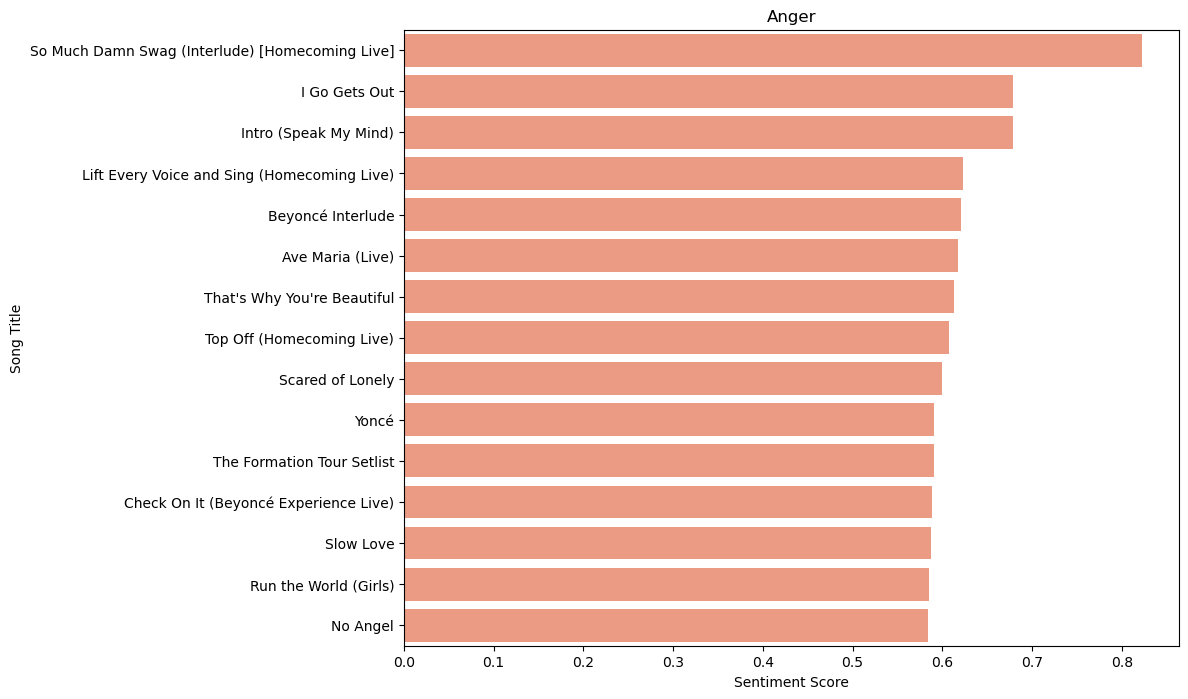

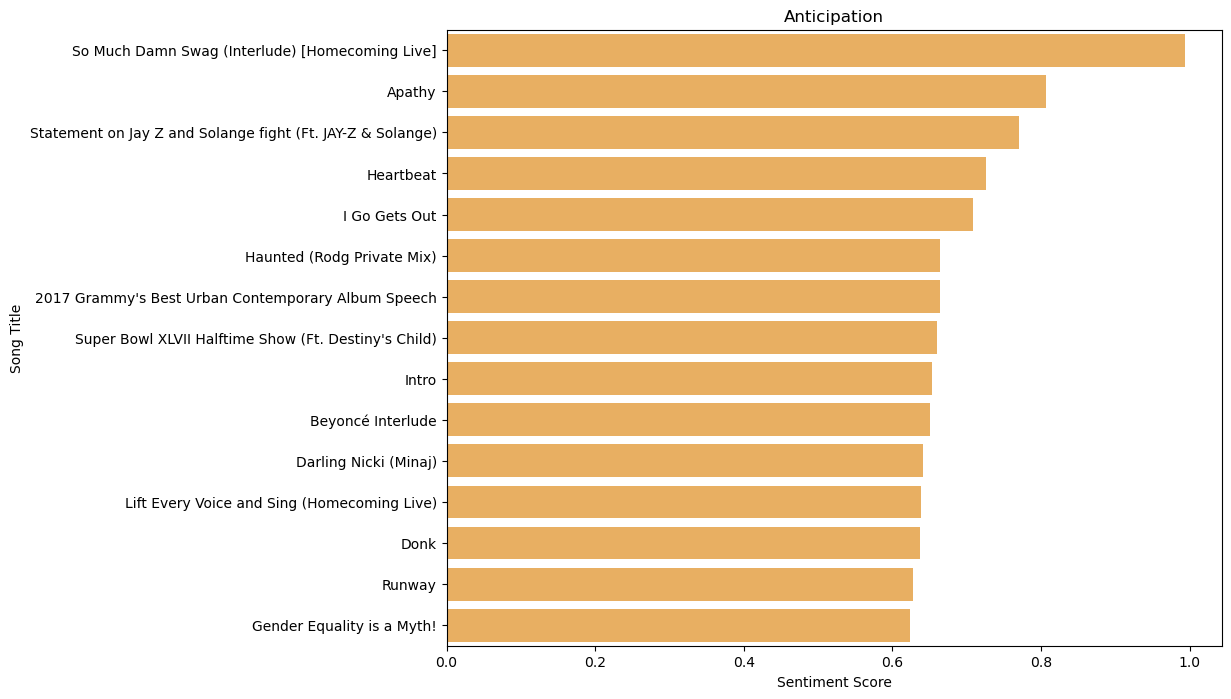

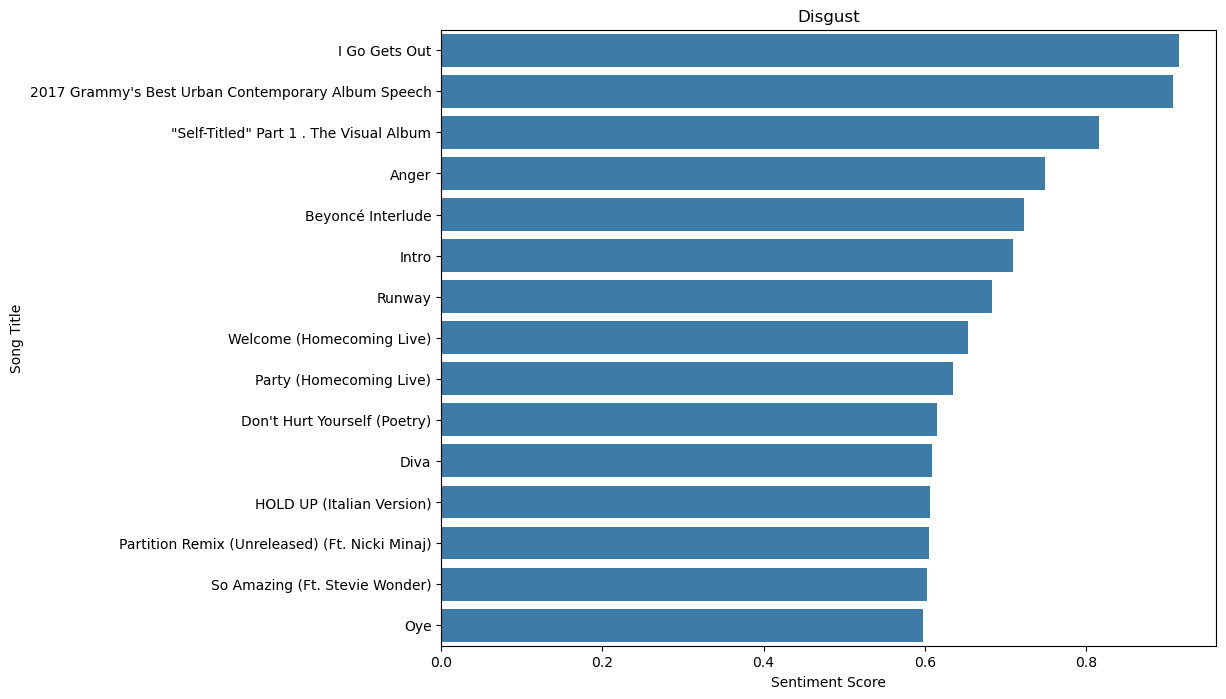

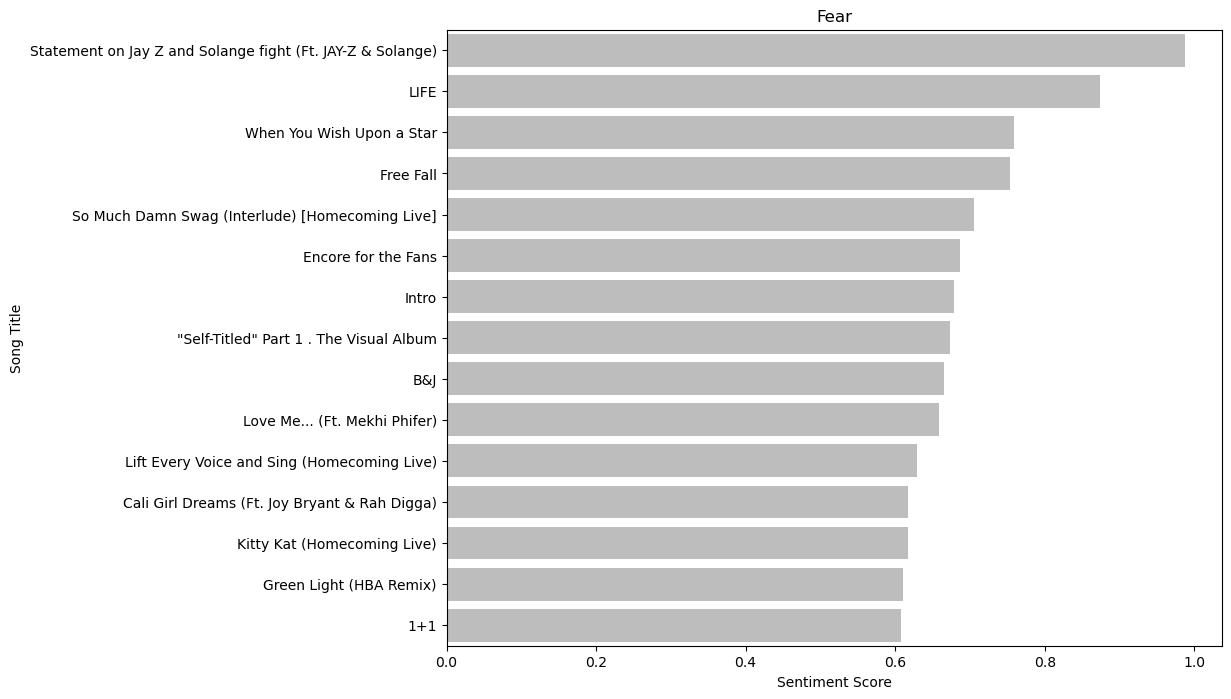

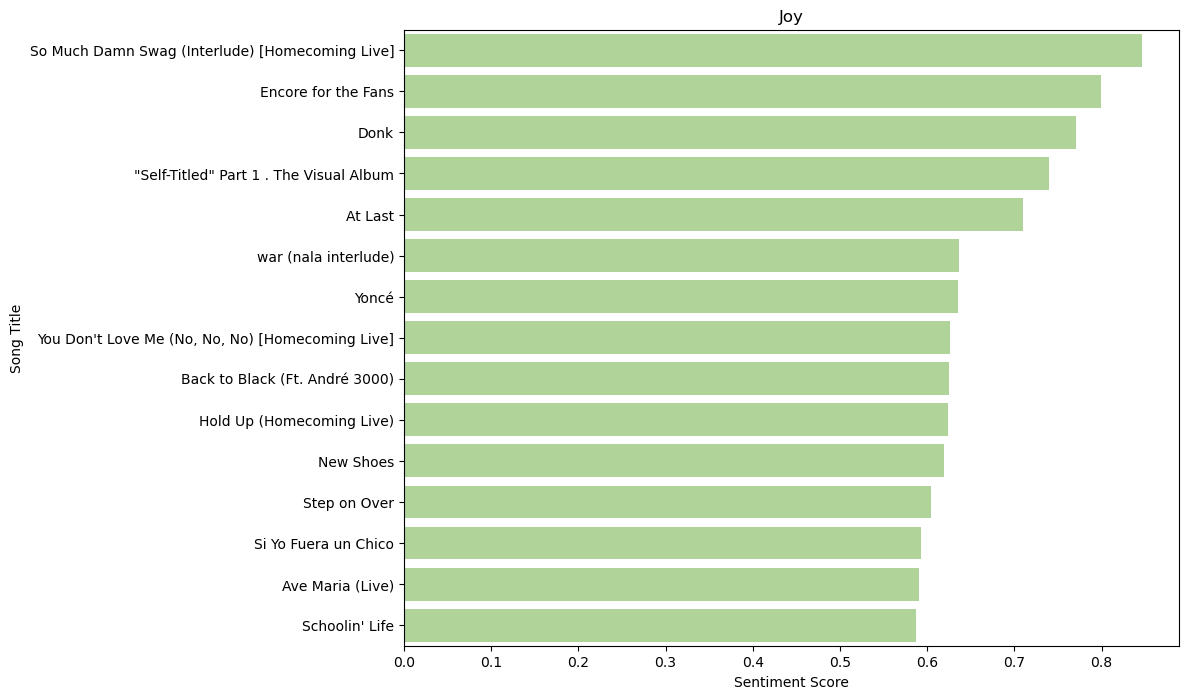

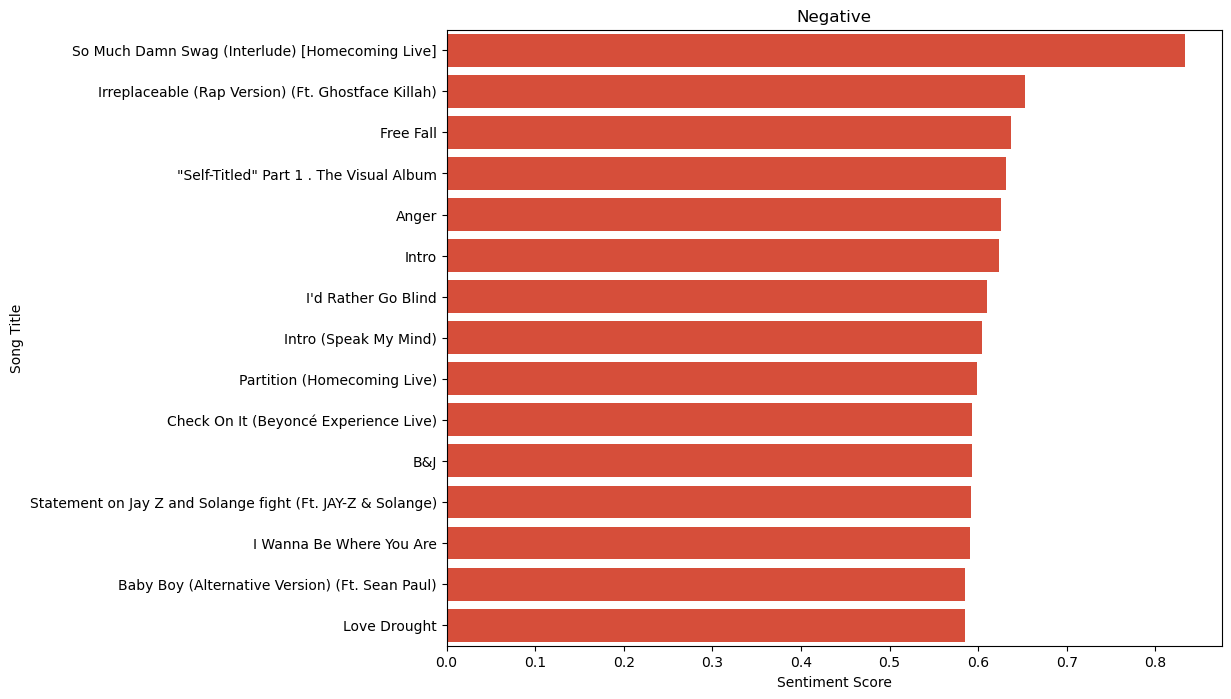

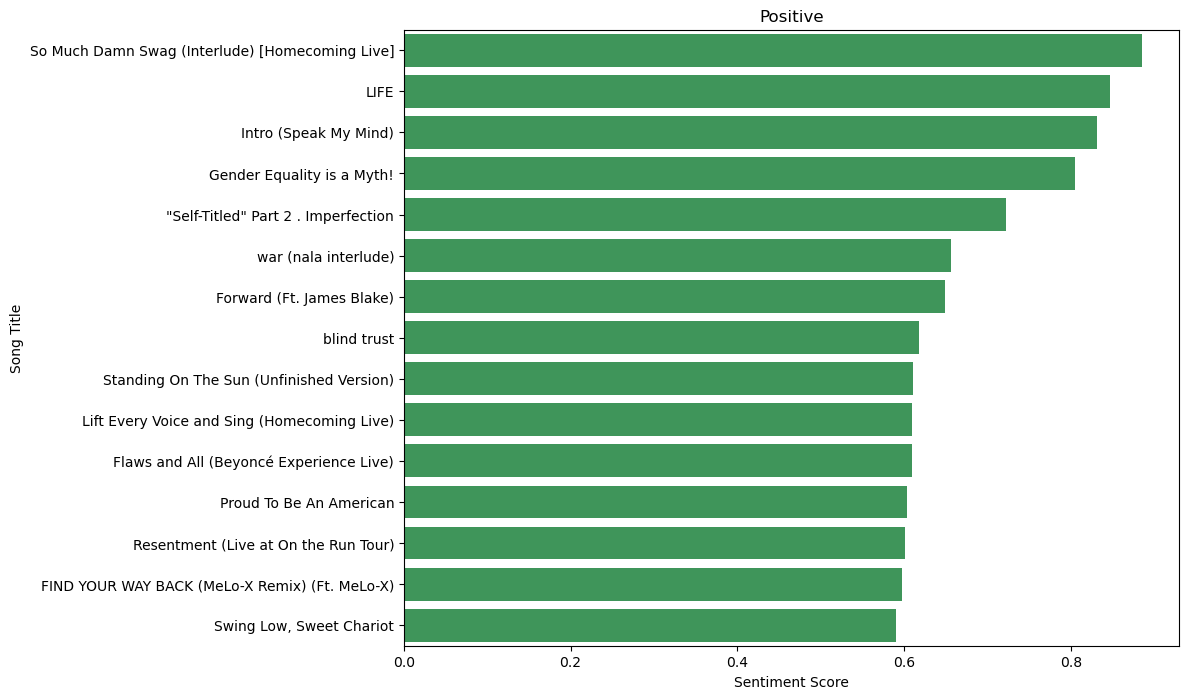

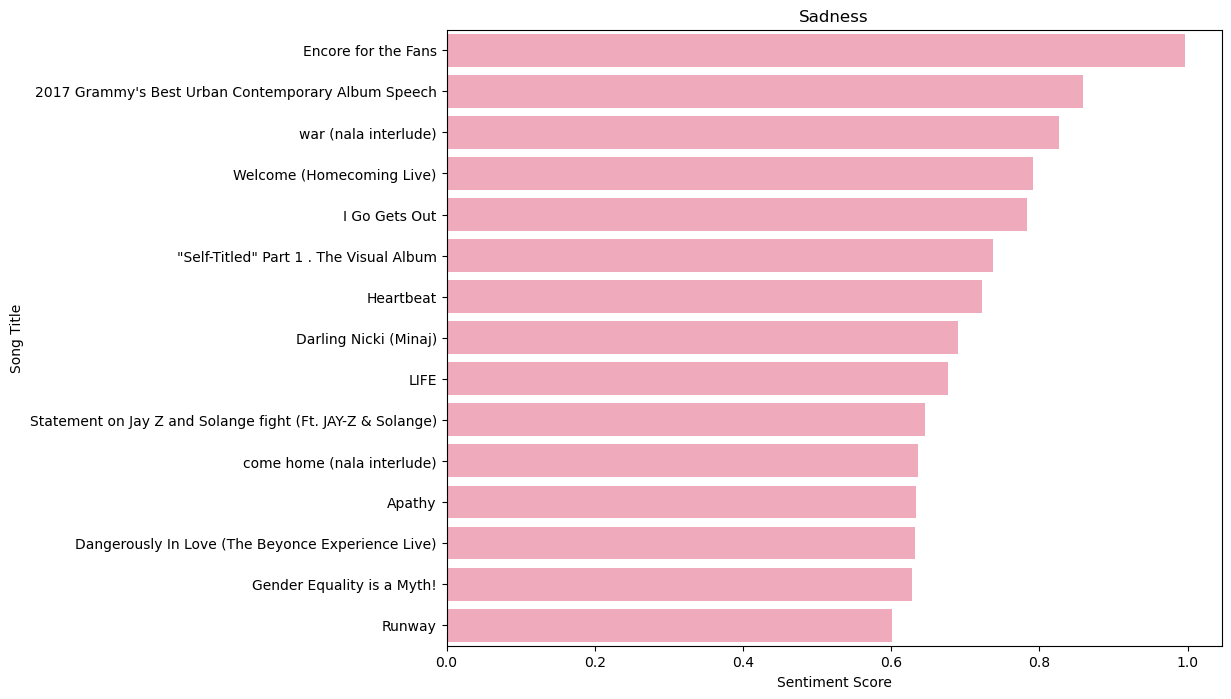

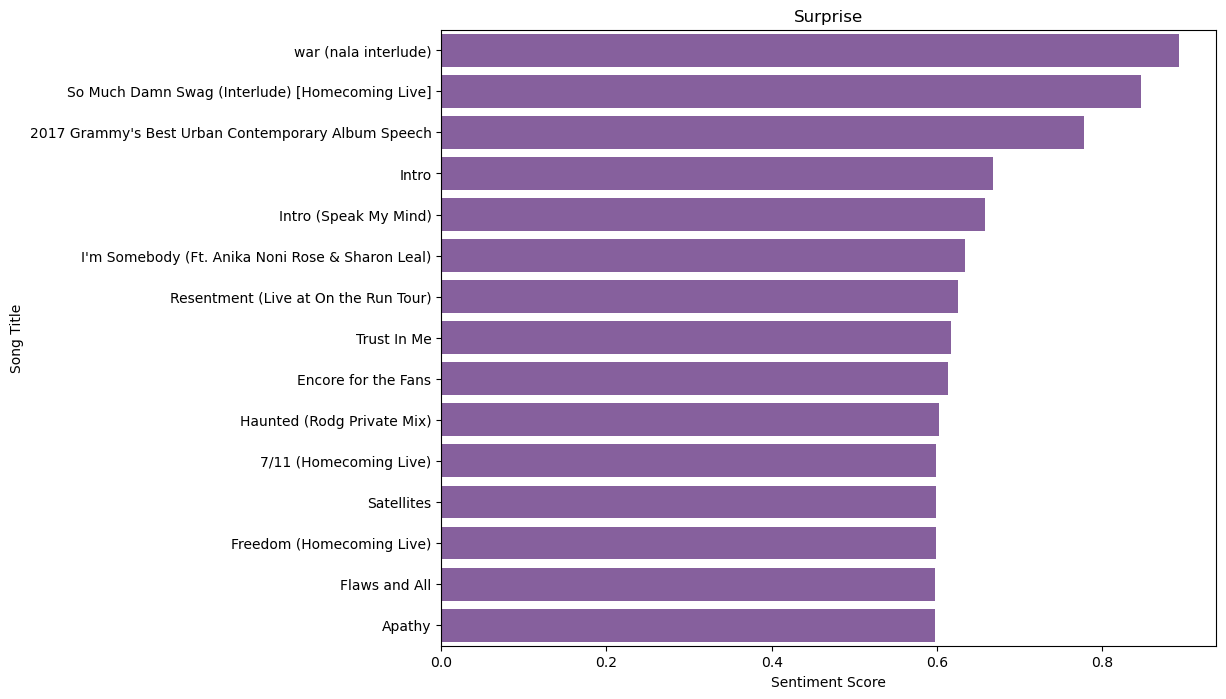

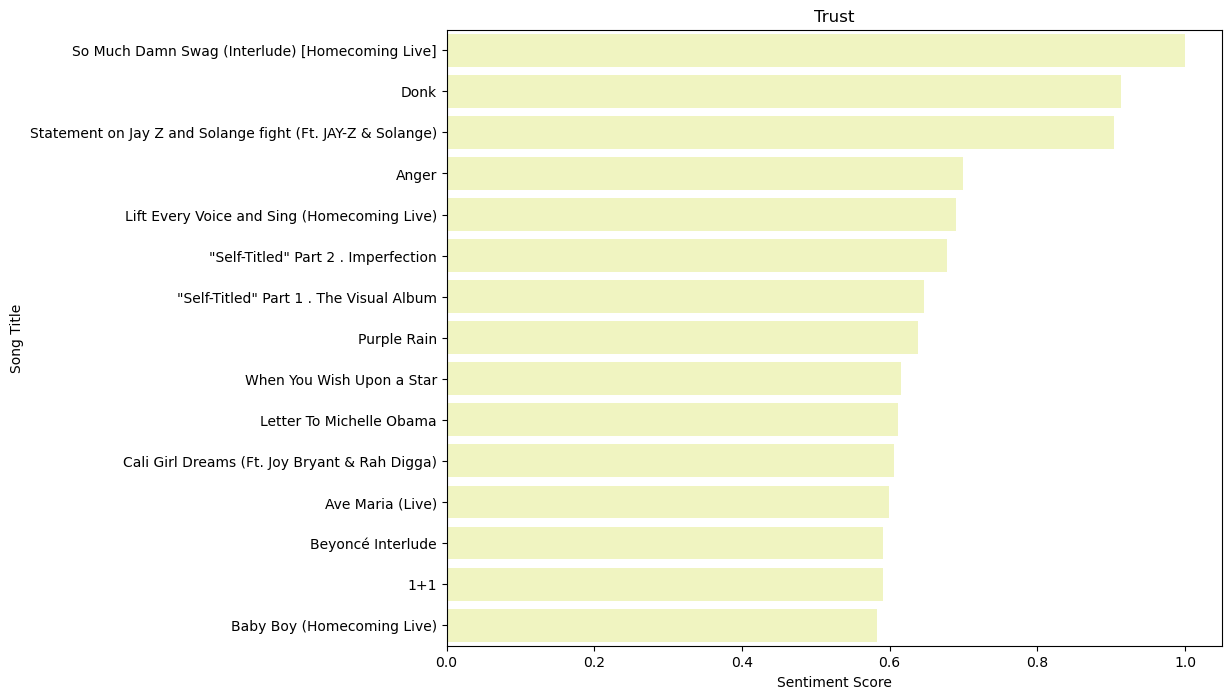

In [5]:

# Define the emotions for which we want to visualize the sentiment scores
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

# Define a color for each emotion
colors = {
    'anger': '#fc9272',
    'anticipation': '#feb24c',
    'disgust': '#2c7fb8',
    'fear': '#bdbdbd',
    'joy': '#addd8e',
    'negative': '#f03b20',
    'positive': '#31a354',
    'sadness': '#fa9fb5',
    'surprise': '#8856a7',
    'trust': '#f7fcb9'
}

# Simulate sentiment scores for the songs
np.random.seed(42)
for emotion in emotions:
    all_lyrics[emotion] = np.random.uniform(0, 1, size=len(all_lyrics))

# Group by 'Title' and calculate mean sentiment score for each emotion
song_sentiments = all_lyrics.groupby('song_name')[emotions].mean().reset_index()

# Melt the DataFrame to have one row per song-sentiment combination
melted_song_sentiments = song_sentiments.melt(id_vars='song_name', var_name='sentiment', value_name='score')

# Now, create a separate plot for each sentiment using the unique color
for emotion in emotions:
    # Select the top 15 songs for the emotion
    top_songs = melted_song_sentiments[melted_song_sentiments['sentiment'] == emotion].nlargest(15, 'score')

    # Create the plot
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_songs, x='score', y='song_name', color=colors[emotion])
    plt.title(f'{emotion.capitalize()}')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Song Title')
    plt.show()
     
        